In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config

In [2]:

# New one with state cost (dt+distance) at each step (with dirt along edge)
# logfile = "mppi_benchmark/old/envs_40_trials_5_densities_4_date_20220907-2234.pickle"
logfile = "mppi_benchmark/envs_40_trials_5_densities_4_date_20220907-2234.pickle"


with open(logfile, 'rb') as fh:
  exp_log = pickle.load(fh)

for k, v in exp_log.items():
  if k not in ["logger"]:
  # if k not in ["logger"]:
    print("{}: {}".format(k, v))

logger = exp_log['logger']
cfg = exp_log['cfg']
max_speed=exp_log['max_speed']
max_steps=exp_log['max_steps']
grid_shape=exp_log['grid_shape']
mud_margin=exp_log['mud_margin']
res=exp_log['res']
num_pmf_bins=exp_log['num_pmf_bins']
bin_values=exp_log['bin_values']
bin_values_bounds=exp_log['bin_values_bounds']
default_mppi_params=exp_log['default_mppi_params']
grass_density_list=exp_log['grass_density_list']
envs_per_density=exp_log['envs_per_density']
trials_per_env=exp_log['trials_per_env']
alpha_list=exp_log['alpha_list']
method_list=exp_log['method_list']
pmf_bounds=exp_log['pmf_bounds']
bush_weights=exp_log['bush_weights']
bush_means=exp_log['bush_means']
bush_std=exp_log['bush_std']
dirt_weights=exp_log['dirt_weights']
dirt_means=exp_log['dirt_means']
dirt_std=exp_log['dirt_std']


sorted_grass_density_list = sorted(grass_density_list)
sorted_alpha_list = sorted(alpha_list)

cfg: <mppi_numba.config.Config object at 0x7f51e07988b0>
max_speed: 3.0
max_steps: 150
grid_shape: (9, 9)
mud_margin: 1
res: 1.0
num_pmf_bins: 22
bin_values: [0.    0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525
 0.575 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.   ]
bin_values_bounds: (0.0, 1.0)
default_mppi_params: {'dt': 0.1, 'x0': array([0.5       , 0.5       , 0.78539816]), 'xgoal': array([8.5, 8.5]), 'goal_tolerance': 0.5, 'v_post_rollout': 0.01, 'cvar_alpha': 1.0, 'lambda_weight': 1.0, 'num_opt': 1, 'u_std': array([2., 2.]), 'vrange': array([0., 3.]), 'wrange': array([-3.14159265,  3.14159265])}
grass_density_list: [0.1, 0.4, 0.7, 1.0]
envs_per_density: 40
trials_per_env: 5
alpha_list: [1.0, 0.8, 0.6, 0.4, 0.2]
method_list: ['noisy_dyn', 'baseline', 'risk_dyn', 'nom_dyn_risk_cost']
pmf_bounds: [0, 1.0]
bush_weights: [0.6, 0.4]
bush_means: [0, 0.8]
bush_std: [0.15, 0.1]
dirt_weights: [1]
dirt_means: [0.65]
dirt_std: [0.1]


In [3]:
# Choose a subset to visualize 
method_list=['noisy_dyn','risk_dyn', 'nom_dyn_risk_cost'] # 'baseline'
method_list=['noisy_dyn',  'risk_dyn', 'nom_dyn_risk_cost'] # 'baseline'



Terrain Vegetation has the following properties for linear and angular tractions.
mean=(0.50, 0.50), std=(0.35, 0.35), cvar(0.30)=(0.07, 0.07) (computed from 10000.0 saved samples)
Terrain Dirt has the following properties for linear and angular tractions.
mean=(0.65, 0.65), std=(0.10, 0.10), cvar(0.30)=(0.54, 0.53) (computed from 10000.0 saved samples)


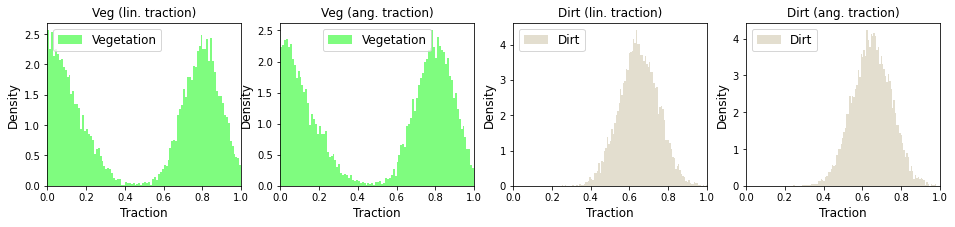

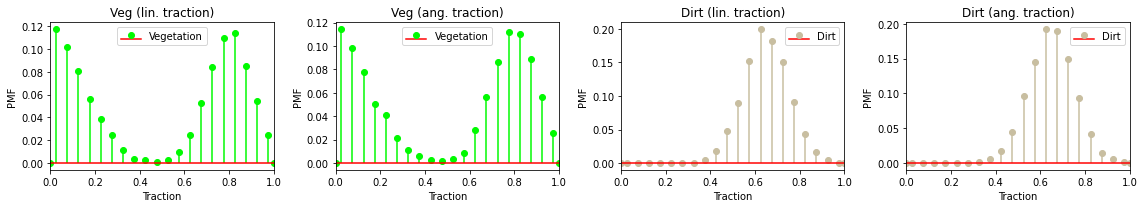

In [4]:
# What percentile of the speed distribution to compute conditional expectation?
cvar_alpha =0.3
num_samples = 1e4
bush_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std, num_samples=num_samples)
bush_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std, num_samples=num_samples)
dirt_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std, num_samples=num_samples)
dirt_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std, num_samples=num_samples)

bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

num_bins=20
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)
LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}
# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density(axes[0], bush_lin_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=num_bins, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=num_bins, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=num_bins, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=num_bins, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()

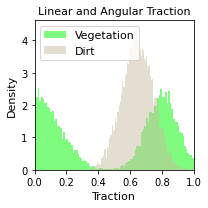

In [5]:
# Visualize the distributions
fontsize=11
fig, ax = plt.subplots(figsize=(3, 3))
vis_density(ax, bush_lin_gm, bush, vis_cvar_alpha=cvar_alpha, title=None, color=bush.rgb, fontsize=fontsize) #, show_legend=False)
vis_density(ax, dirt_lin_gm, dirt, vis_cvar_alpha=cvar_alpha, title=None, color=dirt.rgb, fontsize=fontsize) #, show_legend=False)

ax.set_title("Linear and Angular Traction", fontsize=fontsize)
plt.tight_layout()
# plt.savefig('plots/sim_tractions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


TDM has initialized GPU memory after 0.4396474361419678 s
TDM has initialized GPU memory after 0.0005679130554199219 s


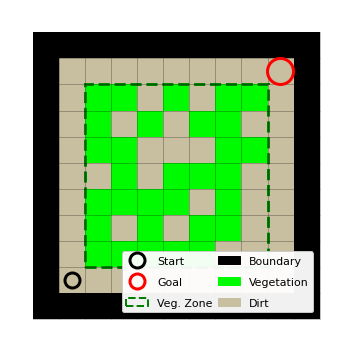

In [6]:
# ------------- Create and visualize the map ------------
# Fixed a sampled environment
# grid_shape = (9, 9)
# grid_shape = (100, 100)
# mud_margin = 1
res = 1.0
# res = 0.1
semantic_grid = np.zeros(grid_shape, dtype=np.int8)
rand_num = np.random.rand(grid_shape[0]-2*mud_margin, grid_shape[1]-2*mud_margin)
# perc_grass = 0.5
perc_grass = 0.6
semantic_grid[mud_margin:-mud_margin, mud_margin:-mud_margin][rand_num<perc_grass] = 1


xlimits = (0,semantic_grid.shape[1]*res)
ylimits = (0,semantic_grid.shape[0]*res)

lin_tdm = TDM_Numba(cfg)
ang_tdm = TDM_Numba(cfg)
lin_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                                  xlimits, ylimits, ID2NAME, NAME2TERRAIN, LIN_TERRAIN2PMG,
                                  default_mppi_params['cvar_alpha'])
ang_tdm.set_TDM_from_semantic_grid(semantic_grid, res, num_pmf_bins, bin_values, bin_values_bounds, 
                                  xlimits, ylimits, ID2NAME, NAME2TERRAIN, ANG_TERRAIN2PMG,
                                  default_mppi_params['cvar_alpha'])

lin_tdm_vis = TDM_Visualizer(lin_tdm)
fig, ax = lin_tdm_vis.draw(figsize=(5, 5))
xgoal = default_mppi_params['xgoal']
x0 = default_mppi_params['x0']
ax.plot([x0[0]], [x0[1]], 'ko', markersize=15, markeredgewidth=3, markerfacecolor='none', label="Start")
c1 = plt.Circle(xgoal, default_mppi_params['goal_tolerance'], color='r', linewidth=3,
fill=False, zorder=6) # label="Goal",
l_dummy = ax.plot([], [], 'ro', markersize=15, markeredgewidth=3, markerfacecolor='none', label="Goal")
r1 = plt.Rectangle((xlimits[0]+mud_margin, ylimits[0]+mud_margin), xlimits[1]-xlimits[0]-2*mud_margin, ylimits[1]-ylimits[0]-2*mud_margin,
fill = False, linewidth=3, edgecolor='g', linestyle='--')#, label="Veg. Zone")
r1_dummy = plt.Rectangle((0,0), 0,0,
fill = False, linewidth=2, edgecolor='g', linestyle='--', label="Veg. Zone")
dummy_rec = plt.Rectangle([0,0], 0,0, color='k', label="Boundary")
dummy_rec_veg = plt.Rectangle([0,0], 0,0, color=np.array((0,250,0))/255.0, label="Vegetation")
dummy_rec_dirt = plt.Rectangle([0,0], 0,0, color=np.array((200,190,160))/255.0, label="Dirt")
ax.add_patch(c1)
ax.add_patch(r1)
ax.add_patch(r1_dummy)
ax.add_patch(dummy_rec)
ax.add_patch(dummy_rec_veg)
ax.add_patch(dummy_rec_dirt)
lgd = ax.legend(bbox_to_anchor=(0.92, 0.08), loc="lower right", ncol=2, fontsize=11.,labelspacing=1.0,
              columnspacing=0.5,)
# lgd = ax.legend(loc='center', fontsize=11.5,
#               # bbox_to_anchor=(0.7, 0.2),
#               bbox_to_anchor=(0.5, 1.0),
#               columnspacing=0.5,
#               labelspacing=1.0, ncol=3)
# lgd.get_frame().set_facecolor('white')
lgd.get_frame().set_alpha(0.95)
plt.tight_layout()
# plt.savefig('plots/sim_env.png', dpi=300, bbox_inches='tight', facecolor='white')

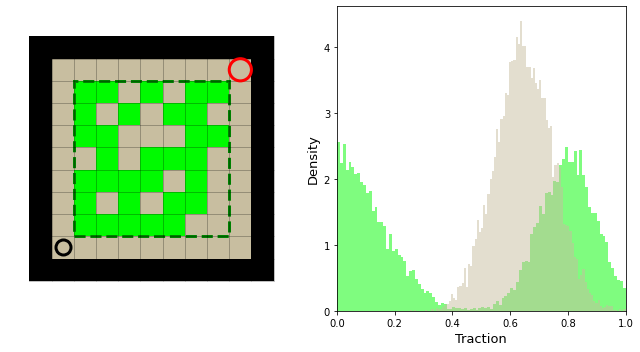

In [7]:
# Visualize the distributions
fontsize=13

fig, axes = plt.subplots(ncols=2, figsize=(9, 5))
ax=axes[0]
_, ax = lin_tdm_vis.draw(ax=ax, figsize=None)
xgoal = default_mppi_params['xgoal']
x0 = default_mppi_params['x0']
ax.plot([x0[0]], [x0[1]], 'ko', markersize=15, markeredgewidth=3, markerfacecolor='none', label="Start")
c1 = plt.Circle(xgoal, default_mppi_params['goal_tolerance'], color='r', linewidth=3,
fill=False, zorder=6) # label="Goal",
l_dummy = ax.plot([], [], 'ro', markersize=15, markeredgewidth=3, markerfacecolor='none', label="Goal")
r1 = plt.Rectangle((xlimits[0]+mud_margin, ylimits[0]+mud_margin), xlimits[1]-xlimits[0]-2*mud_margin, ylimits[1]-ylimits[0]-2*mud_margin,
fill = False, linewidth=3, edgecolor='g', linestyle='--')#, label="Veg. Zone")
r1_dummy = plt.Rectangle((0,0), 0,0,
fill = False, linewidth=2, edgecolor='g', linestyle='--', label="Veg. Zone")
dummy_rec = plt.Rectangle([0,0], 0,0, color='k', label="Boundary")
dummy_rec_veg = plt.Rectangle([0,0], 0,0, color=np.array((0,250,0))/255.0, label="Vegetation")
dummy_rec_dirt = plt.Rectangle([0,0], 0,0, color=np.array((200,190,160))/255.0, label="Boundary")
ax.add_patch(c1)
ax.add_patch(r1)
ax.add_patch(r1_dummy)
ax.add_patch(dummy_rec)
ax.add_patch(dummy_rec_veg)
ax.add_patch(dummy_rec_dirt)
# ax.legend(loc="upper center", ncol=4)
# lgd = ax.legend(loc='center',
#               # bbox_to_anchor=(0.7, 0.2),
#               bbox_to_anchor=(0.5, 1.0),
#               columnspacing=0.5,
#               labelspacing=1.0, ncol=3)
# lgd.get_frame().set_facecolor('white')
# lgd.get_frame().set_alpha(0.9)

ax=axes[1]
vis_density(ax, bush_lin_gm, bush, vis_cvar_alpha=cvar_alpha, title=None, color=bush.rgb, fontsize=fontsize, show_legend=False)
vis_density(ax, dirt_lin_gm, dirt, vis_cvar_alpha=cvar_alpha, title=None, color=dirt.rgb, fontsize=fontsize, show_legend=False)

# ax.set_title("Linear and Angular Traction", fontsize=fontsize)
plt.tight_layout()
# plt.savefig('plots/sim_tractions.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

,time_to_goal,success,dist_to_goal,dirt_along_edge,grass_density,grass_density_index,sem_map_index,method,alpha,map_sample_index
0,7.1,True,NaN,True,0.1,0,0,noisy_dyn,1.0,0
1,6.6,True,NaN,True,0.1,0,0,noisy_dyn,1.0,1
2,6.0,True,NaN,True,0.1,0,0,noisy_dyn,1.0,2
3,7.8,True,NaN,True,0.1,0,0,noisy_dyn,1.0,3
4,6.5,True,NaN,True,0.1,0,0,noisy_dyn,1.0,4
...,...,...,...,...,...,...,...,...,...,...
15995,NaN,False,2.731247,True,1.0,3,39,nom_dyn_risk_cost,0.2,0
15996,NaN,False,1.868208,True,1.0,3,39,nom_dyn_risk_cost,0.2,1
15997,12.5,True,NaN,True,1.0,3,39,nom_dyn_risk_cost,0.2,2
15998,NaN,False,8.353643,True,1.0,3,39,nom_dyn_risk_cost,0.2,3


dirt along the edges? :False


/tmp/ipykernel_60551/3741822555.py:41: RuntimeWarning: invalid value encountered in long_scalars
  success_rate.append(sub_logger['success'].sum()/len(sub_logger))


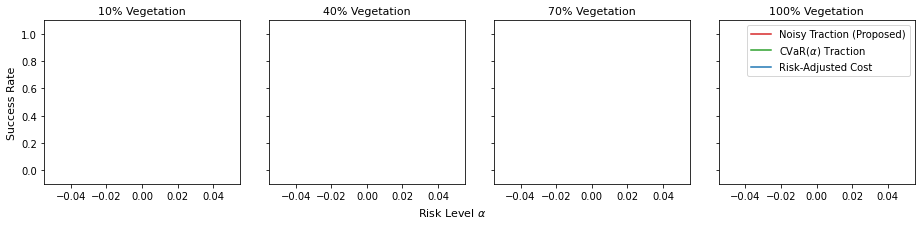

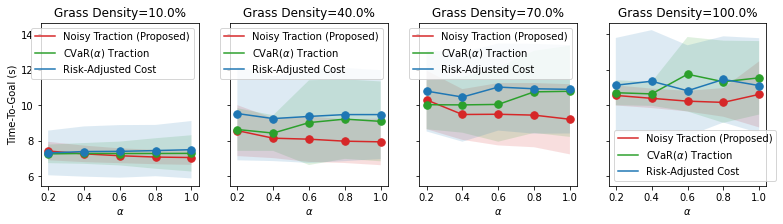

dirt along the edges? :True


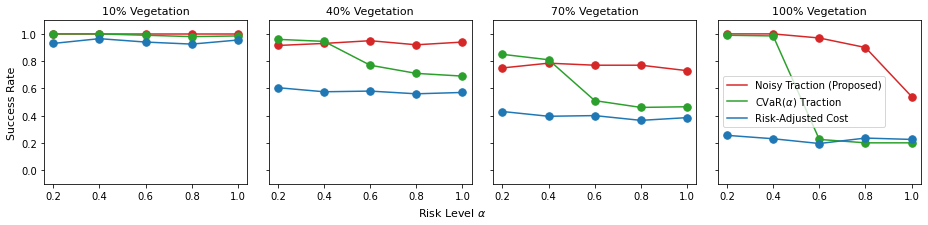

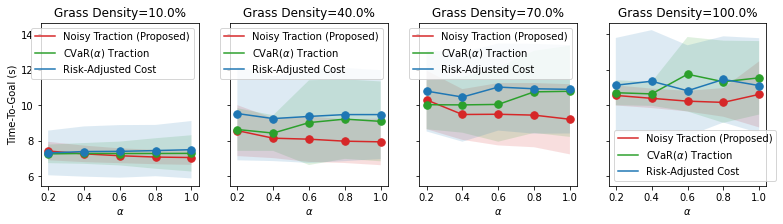

In [8]:
display(logger)

method2rgb = {
  'noisy_dyn': 'tab:red',
  # 'wayfast': 'orange',
  'risk_dyn': 'tab:green',
  'nom_dyn_risk_cost': 'tab:blue',
  'baseline': 'k'
}
# method2label = {
#   'noisy_dyn': 'Noisy Traction',
#   'risk_dyn': r'CVaR($\alpha$) Traction',
#   'nom_dyn_risk_cost': 'Risk-Adjusted Cost'
# }
method2label = {
  'noisy_dyn': 'Noisy Traction (Proposed)',
  # 'noisy_dyn_2x_env': "Noisy Traction (2x Env Samples)",
  'risk_dyn': r'CVaR($\alpha$) Traction',
  'nom_dyn_risk_cost': 'Risk-Adjusted Cost',
  'baseline': "Nominal Dynamics"
}

def success_rate_plot(logger, dirt_along_edge=False, figsize=(12,4), fontsize=12):

  # Plot success rate vs. alpha for each method
  fig, axes = plt.subplots(nrows=1, ncols=len(sorted_grass_density_list), sharey=True, figsize=figsize)

  for density_i, grass_density in enumerate(sorted_grass_density_list):
    if len(sorted_grass_density_list)==1:
      ax=axes
    else:
      ax = axes[density_i]
    for method in method_list:
      success_rate = []
      for alpha in sorted_alpha_list:
        sub_logger = logger[
          (logger['grass_density']==grass_density) & \
          (logger['method']==method) & \
          (logger['alpha']==alpha) & \
          (logger['dirt_along_edge']==dirt_along_edge)]
        success_rate.append(sub_logger['success'].sum()/len(sub_logger))
      success_rate = np.asarray(success_rate)
      ax.plot(sorted_alpha_list, success_rate, '-', color=method2rgb[method], label=method2label[method])
      ax.plot(sorted_alpha_list, success_rate, '.', color=method2rgb[method], markersize=15)
    if density_i==len(sorted_grass_density_list)-1:
      ax.legend(fontsize=fontsize-1)
    ax.set_ylim([-0.1,1.1])
    if density_i==0:
      ax.set_ylabel('Success Rate', fontsize=fontsize)
    # ax.set_xlabel(r'$\alpha$', fontsize=fontsize)
    ax.set_title('{:.0f}% Vegetation'.format(grass_density*100), fontsize=fontsize)
  fig.text(0.45, -0.02, r'Risk Level $\alpha$', fontsize=fontsize)
  fig.tight_layout()

  # Plot time-to-goal for successful trials for each alpha
  fig, axes = plt.subplots(ncols=len(sorted_grass_density_list), sharey=True, figsize=figsize)
  for density_i, grass_density in enumerate(sorted_grass_density_list):
    if len(sorted_grass_density_list)==1:
      ax=axes
    else:
      ax = axes[density_i]
    for method in method_list:
      t2g = []
      t2g_std = []
      for alpha in sorted_alpha_list:
        sub_logger = logger[logger['success'] & (logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha)]
        if len(sub_logger)>0:
          t2g.append(sub_logger['time_to_goal'].sum()/len(sub_logger))
          t2g_std.append(sub_logger['time_to_goal'].std())
        else:
          t2g.append(np.nan)
          t2g_std.append(np.nan)

          
      t2g = np.asarray(t2g)
      t2g_std = np.asarray(t2g_std)
      ax.plot(sorted_alpha_list, t2g, '-', color=method2rgb[method], label=method2label[method])
      ax.fill_between(sorted_alpha_list, t2g-t2g_std, t2g+t2g_std,
                alpha=0.15, edgecolor='none', facecolor=method2rgb[method])
      ax.plot(sorted_alpha_list, t2g, '.', color=method2rgb[method], markersize=15)
    ax.legend()
    if density_i==0:
      ax.set_ylabel('Time-To-Goal (s)')
    ax.set_xlabel(r'$\alpha$')
    ax.set_title('Grass Density={:.1f}%'.format(grass_density*100))

  return fig, axes


figsize=(13,3)
fontsize=11
for dirt_along_edge in [False, True]:
  print("dirt along the edges? :{}".format(dirt_along_edge))
  fig, axes = success_rate_plot(logger, dirt_along_edge=dirt_along_edge, figsize=figsize, fontsize=fontsize)
  plt.show()

### Boxplot for the time-to-goal in successful trials

In [9]:
# Visualization the time-to-goal using boxplots instead
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def make_boxplot(data, tick_labels, alg_names, colors, group_length=2, space_between_group = 0.3, 
                 space_between_box = 0.1, use_dividing_line=True, xlabel=None, ylabel=None, title=None,
                alg2legends=None, ax=None, show_legend=True, fontsize=10):

    tick_group_width = group_length - space_between_group
    width = (tick_group_width - space_between_box*(len(alg_names)-1)) / (len(alg_names))
    
    if not ax:
        fig, ax = plt.subplots()

    # Dividing lines
    if use_dividing_line:
        offset = -tick_group_width/2. + (width+space_between_box)*(len(alg_names))+space_between_group/2.0
        dividing_xpos = np.array(range(len(tick_labels)))*group_length+offset
        for xpos in dividing_xpos:
            ax.axvline(xpos, color = 'gray', linestyle='--', alpha=0.5) 

    for idx, alg in enumerate(alg_names):
        offset = -tick_group_width/2. + (width+space_between_box)*(idx+0.5)
        bp = ax.boxplot(data[alg], positions=np.array(range(len(tick_labels)))*group_length+offset, 
                         sym='', widths=width)
        set_box_color(bp, colors[alg]) 

        # draw temporary red and blue lines and use them to create a legend
        if alg2legends:
            ax.plot([], c=colors[alg], label=alg2legends[alg])
        else:
            ax.plot([], c=colors[alg], label=alg)
        if show_legend:
            ax.legend()
    ax.set_xticks(range(0, len(tick_labels) * group_length, group_length), tick_labels)
    ax.set_xlim(-0.5*group_length, len(tick_labels)*group_length - 0.5*group_length)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fontsize)
    if title:
        ax.set_title(title, fontsize=fontsize)

    plt.tight_layout()
    
    return ax

def get_boxplot_logger(df, column_name, grass_density, algs, alpha_list, dirt_along_edge, scale=1.0):
    logger = dict()
    grass_density_mask = df['grass_density']==grass_density
    success_mask = df['success']
    for alg in algs:
        logger[alg] = []
        alg_mask = df["method"]==alg
        dir_mask = df["dirt_along_edge"]==dirt_along_edge
        for alpha_idx, alpha in enumerate(alpha_list):
            alpha_mask = df["alpha"]==alpha
            logger[alg].append(df[success_mask&alpha_mask&alg_mask&grass_density_mask&dir_mask][column_name].to_numpy()*scale)
    return logger

dirt_along_edge: True


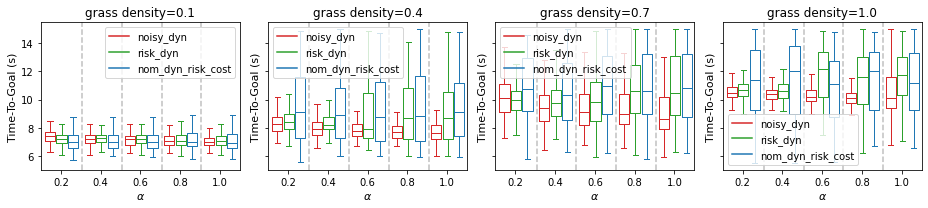

In [10]:
for dirt_along_edge in [True]:
  print("dirt_along_edge: {}".format(dirt_along_edge))
  column_name = 'time_to_goal'
  fig, axes = plt.subplots(nrows=1, ncols=len(sorted_grass_density_list), sharey=True, figsize=figsize)
  for ax, grass_density in zip(axes, sorted_grass_density_list):
    boxplot_logger = get_boxplot_logger(logger, column_name, grass_density, method_list, sorted_alpha_list,
                          dirt_along_edge=dirt_along_edge)
    xticks = sorted_alpha_list
    ax = make_boxplot(boxplot_logger, xticks, method_list, method2rgb,
                          group_length = 3, space_between_group = 0.5,
                          space_between_box = 0.1,
                          title='',
                          xlabel=r"$\alpha$",
                          ylabel="Time-To-Goal (s)",
                          ax=ax,
                          fontsize=fontsize,
                          show_legend=True)
    ax.set_title("grass density={}".format(grass_density))
  plt.show()
  

dirt_along_edge: True


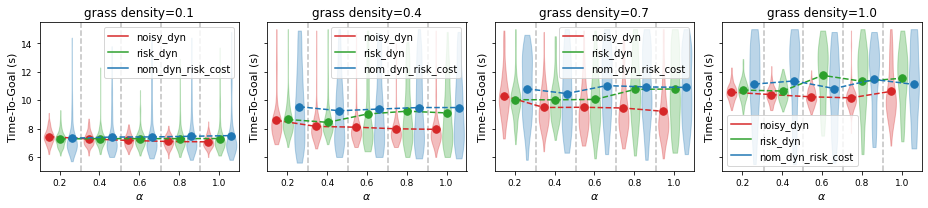

In [11]:
def set_violin_color(bp, color):
    for key in bp:
        plt.setp(bp[key], color=color)

    # plt.setp(bp['cmeans'], color=color)
    # plt.setp(bp['caps'], color=color)
    # plt.setp(bp['medians'], color=color)


def make_violinplot(data, tick_labels, alg_names, colors, group_length=2, space_between_group = 0.3, 
                 space_between_box = 0.1, use_dividing_line=True, xlabel=None, ylabel=None, title=None,
                alg2legends=None, ax=None, show_legend=True, fontsize=10, tickfontsize=10):

    tick_group_width = group_length - space_between_group
    width = (tick_group_width - space_between_box*(len(alg_names)-1)) / (len(alg_names))
    
    if not ax:
        fig, ax = plt.subplots()

    # Dividing lines
    if use_dividing_line:
        offset = -tick_group_width/2. + (width+space_between_box)*(len(alg_names))+space_between_group/2.0
        dividing_xpos = np.array(range(len(tick_labels)))*group_length+offset
        for xpos in dividing_xpos:
            ax.axvline(xpos, color = 'gray', linestyle='--', alpha=0.5) 

    alg_to_positions = {}
    for idx, alg in enumerate(alg_names):
        offset = -tick_group_width/2. + (width+space_between_box)*(idx+0.5)
        positions = np.array(range(len(tick_labels)))*group_length+offset
        alg_to_positions[alg] = positions
        bp = ax.violinplot(data[alg], positions=positions, 
                          widths=width, showmeans=False, showextrema=False)
        set_violin_color(bp, colors[alg]) 

        # draw temporary red and blue lines and use them to create a legend
        if show_legend:
            if alg2legends:
                ax.plot([], c=colors[alg], label=alg2legends[alg])
            else:
                ax.plot([], c=colors[alg], label=alg)
            ax.legend()

    for alg in alg_names:
        ax.plot(alg_to_positions[alg], [d.mean() for d in data[alg]], '.--', markersize=15, color=colors[alg])

    ax.set_xticks(range(0, len(tick_labels) * group_length, group_length), tick_labels)
    ax.set_xlim(-0.5*group_length, len(tick_labels)*group_length - 0.5*group_length)
    ax.tick_params(axis='x', labelsize=fontsize-2)
    ax.tick_params(axis='y', labelsize=fontsize-2)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fontsize)
    if title:
        ax.set_title(title, fontsize=fontsize)

    plt.tight_layout()
    
    return ax



# figsize = (20, 5)

# for dirt_along_edge in [True, False]:
# for dirt_along_edge in [True]:
for dirt_along_edge in [True]:
  print("dirt_along_edge: {}".format(dirt_along_edge))
  column_name = 'time_to_goal'
  fig, axes = plt.subplots(nrows=1, ncols=len(sorted_grass_density_list), sharey=True, figsize=figsize)
  for ax, grass_density in zip(axes, sorted_grass_density_list):
    boxplot_logger = get_boxplot_logger(logger, column_name, grass_density, method_list, sorted_alpha_list,
                          dirt_along_edge=dirt_along_edge)
    xticks = sorted_alpha_list
    make_violinplot(boxplot_logger, xticks, method_list, method2rgb,
                          group_length = 3, space_between_group = 0.5,
                          space_between_box = 0.1,
                          title='',
                          xlabel=r"$\alpha$",
                          ylabel="Time-To-Goal (s)",
                          ax=ax,
                          fontsize=fontsize,
                          show_legend=True)

    # for idx, alg in enumerate(['noisy_dyn','risk_dyn']): #, 'nom_dyn_risk_cost']):
    #   ax.violinplot(boxplot_logger[alg])

    ax.set_title("grass density={}".format(grass_density))
  plt.show()

    

### Combine previous two plots?


With dirt along edge


/tmp/ipykernel_60551/2642420249.py:123: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(line_objs,


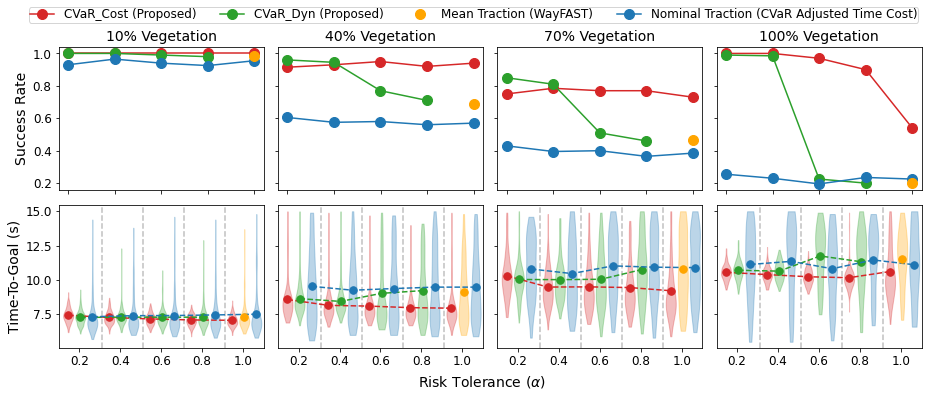

In [12]:
def set_violin_color(bp, color):
    for key in bp:
        plt.setp(bp[key], color=color)

    # plt.setp(bp['cmeans'], color=color)
    # plt.setp(bp['caps'], color=color)
    # plt.setp(bp['medians'], color=color)


def make_violinplot(data, tick_labels, alg_names, colors, group_length=2, space_between_group = 0.3, 
                 space_between_box = 0.1, use_dividing_line=True, xlabel=None, ylabel=None, title=None,
                alg2legends=None, ax=None, show_legend=True, fontsize=10, tickfontsize=10):

    tick_group_width = group_length - space_between_group
    width = (tick_group_width - space_between_box*(len(alg_names)-1)) / (len(alg_names))
    
    if not ax:
        fig, ax = plt.subplots()

    # Dividing lines
    if use_dividing_line:
        offset = -tick_group_width/2. + (width+space_between_box)*(len(alg_names))+space_between_group/2.0
        dividing_xpos = np.array(range(len(tick_labels)))*group_length+offset
        for xpos in dividing_xpos:
            ax.axvline(xpos, color = 'gray', linestyle='--', alpha=0.5) 

    alg_to_positions = {}
    for idx, alg in enumerate(alg_names):

        if alg == "risk_dyn":
          offset = -tick_group_width/2. + (width+space_between_box)*(idx+0.5)
          positions = np.array(range(len(tick_labels)))*group_length+offset
          alg_to_positions[alg] = positions
          bp = ax.violinplot(data[alg], positions=positions, 
                            widths=width, showmeans=False, showextrema=False)
          set_violin_color(bp, colors[alg]) 

          # Change last color manually
          for i, key in enumerate(bp):
            
            if i==len(bp)-1:

                plt.setp(bp[key][-1], color='orange')

          # draw temporary red and blue lines and use them to create a legend
          if show_legend:
              if alg2legends:
                  ax.plot([], c=colors[alg], label=alg2legends[alg])
              else:
                  ax.plot([], c=colors[alg], label=alg)
              ax.legend()
        else:

          offset = -tick_group_width/2. + (width+space_between_box)*(idx+0.5)
          positions = np.array(range(len(tick_labels)))*group_length+offset
          alg_to_positions[alg] = positions
          bp = ax.violinplot(data[alg], positions=positions, 
                            widths=width, showmeans=False, showextrema=False)
          set_violin_color(bp, colors[alg]) 

          # draw temporary red and blue lines and use them to create a legend
          if show_legend:
              if alg2legends:
                  ax.plot([], c=colors[alg], label=alg2legends[alg])
              else:
                  ax.plot([], c=colors[alg], label=alg)
              ax.legend()

    for alg in alg_names:
        if alg == "risk_dyn":
          ax.plot(alg_to_positions[alg][:-1], [d.mean() for d in data[alg]][:-1], '.--', markersize=15, color=colors[alg])
          ax.plot(alg_to_positions[alg][-1], [d.mean() for d in data[alg]][-1], '.--', markersize=15, color='orange', zorder=6)
        else:
          ax.plot(alg_to_positions[alg], [d.mean() for d in data[alg]], '.--', markersize=15, color=colors[alg])

    ax.set_xticks(range(0, len(tick_labels) * group_length, group_length), tick_labels)
    ax.set_xlim(-0.5*group_length, len(tick_labels)*group_length - 0.5*group_length)
    ax.tick_params(axis='x', labelsize=fontsize-2)
    ax.tick_params(axis='y', labelsize=fontsize-2)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fontsize)
    if title:
        ax.set_title(title, fontsize=fontsize)

    plt.tight_layout()
    
    return ax


def plot_joint_success_and_time(method2label, dirt_along_edge, fontsize, figsize):

  fig, axes_2rows = plt.subplots(nrows=2, ncols=len(sorted_grass_density_list), sharey='row', figsize=figsize)

  # Success rate
  # Plot success rate vs. alpha for each method
  axes=axes_2rows[0]
  for density_i, grass_density in enumerate(sorted_grass_density_list):
    ax = axes[density_i]
    line_objs = []
    for method in method_list:
      success_rate = []
      for alpha in sorted_alpha_list:
        sub_logger = logger[
          (logger['grass_density']==grass_density) & \
          (logger['method']==method) & \
          (logger['alpha']==alpha) & \
          (logger['dirt_along_edge']==dirt_along_edge)]
        success_rate.append(sub_logger['success'].sum()/len(sub_logger))
      success_rate = np.asarray(success_rate)
      if method == "risk_dyn":
        l = ax.plot(sorted_alpha_list[:-1], success_rate[:-1], '-o', color=method2rgb[method], label=method2label[method], markersize=10)
        lwf = ax.plot([sorted_alpha_list[-1]], [success_rate[-1]], 'o', color="orange", label="Mean Traction (WayFAST)", markersize=10, zorder=6)
        line_objs.append(lwf)
        line_objs.append(l) 
      else:
        l = ax.plot(sorted_alpha_list, success_rate, '-o', color=method2rgb[method], label=method2label[method], markersize=10)
        line_objs.append(l) 
      
    if density_i==0:
      fig.legend(line_objs, 
            # labels=['noisy_dyn', 'risk_dyn', 'wayfast', 'nom_dyn_risk_cost'],
            labels=['CVaR_Cost (Proposed)', 'CVaR_Dyn (Proposed)', 'Mean Traction (WayFAST)', 'Nominal Traction (CVaR Adjusted Time Cost)'],
                # labels=[method2label[alg] for alg in method_list],
              loc="upper center", ncol=4, fontsize=fontsize-2,
              bbox_to_anchor=(0.51, 1.05),
              # columnspacing=0.8,
              borderpad=0.1)

    # ax.set_ylim([-0.1,1.1])
    if density_i==0:
      ax.set_ylabel('Success Rate', fontsize=fontsize)
    # ax.set_xlabel(r'$\alpha$', fontsize=fontsize)
    ax.set_xticklabels("")
    ax.tick_params(axis='y', labelsize=fontsize-2)
    ax.set_title('{:.0f}% Vegetation'.format(grass_density*100), fontsize=fontsize)

  # Violin
  column_name = 'time_to_goal'
  axes=axes_2rows[1]
  for i, (ax, grass_density) in enumerate(zip(axes, sorted_grass_density_list)):
    boxplot_logger = get_boxplot_logger(logger, column_name, grass_density, method_list, sorted_alpha_list,
                          dirt_along_edge=dirt_along_edge)
    xticks = sorted_alpha_list

    ax = make_violinplot(boxplot_logger, xticks, method_list, method2rgb,
                          group_length = 3, space_between_group = 0.5,
                          space_between_box = 0.15,
                          title='',
                          xlabel=None,
                          ylabel="Time-To-Goal (s)" if i==0 else None,
                          ax=ax,
                          fontsize=fontsize,
                          tickfontsize=fontsize-2,
                          show_legend=False)
  fig.text(0.45, -0.02, r'Risk Tolerance $(\alpha$)', fontsize=fontsize)

  return fig, axes_2rows




method2label = {
  'noisy_dyn': "Stochastic Traction "+r"($\bf{Proposed}$)"+"\n"+r"CVaR($\alpha$) of Objective",
  'risk_dyn': "Deterministic Traction\n"+r"CVaR($\alpha$) of Traction",
  'nom_dyn_risk_cost': "Nominal Traction\n"+r"Time Cost Adjusted by CVaR($\alpha$) of Linear Traction",
  'baseline': "Nominal Dynamics"
}

figsize=(13,5)
fontsize=14
print("With dirt along edge")
fig, axes = plot_joint_success_and_time(method2label, dirt_along_edge=True, fontsize=fontsize, figsize=figsize)

# fig, axes = plot_joint_success_and_time(method2label, dirt_along_edge=False, fontsize=fontsize, figsize=figsize)
fig.tight_layout()
 
# plt.savefig('plots/sim_benchmark_show_wayfast.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
